# Curso: CC521 A Programación Evolutiva 2022-1
Alumno: Jordi Joel Bardales Rojas

## Práctica dirigida: Representación y Selección 


In [13]:
from __future__ import annotations
import math
import numpy as np
from enum import Enum
from bin_repr import dec2bin, bin2gray, my_map, inverse_map, bin2dec, gray2bin
import copy
import random
import matplotlib.pyplot as plt
from typing import Callable, NamedTuple
from itertools import combinations
from abc import ABC, abstractmethod


## Algoritmo Genético binario (Cuaderno de notas del Colab)

Para las dos primeras funciones de De Jong:


In [14]:
F1 = lambda x: x[0]**2 + x[1]**2 + x[2]**2
F2 = lambda x: 100 * (x[0]**2 - x[1])**2 + (1 - x[0])**2
# dominio
domain_1, n_var_1 = [-1.0, 1], 3
domain_2, n_var_2 = [-2, 2.0], 2


Parámetros del individuo tipados

In [15]:
class IndividualArguments(NamedTuple):
    domain: tuple[int, int]
    eps: float
    n_var: int
    gen_size: int


Usando las métricas "en linea" y "fuera de linea" realizar lo siguiente:

### 1. Determinar el tamaño de la población para ambas funciones, Seleccionar los hiperparámetros iniciales de acuerdo a su criterio

### Algoritmo genético

#### Representación

In [16]:
class Individual():
    def __init__(self, phenotype: list[float], args: IndividualArguments):
        self.domain = args.domain
        self.eps = args.eps
        self.n_var = args.n_var
        self.gen_size = args.gen_size
        self.phenotype = phenotype

    def getGenotype(self):
        list_repr: list[int] = []
        for gen in self.phenotype:
            list_repr.extend(bin2gray(dec2bin(num=my_map(gen, self.domain[0], self.domain[1], self.eps), bits=self.gen_size)))
        return list_repr

    @classmethod
    def new(cls, genotype, args: IndividualArguments):
        phenotype: list[int] = []
        for k in range(args.n_var):
            gen = genotype[args.gen_size * k:args.gen_size * (k + 1)]
            phenotype.append(inverse_map(bin2dec(gray2bin(gen)), args.domain[0], args.eps))
        return cls(phenotype, args)

    @staticmethod
    def newLike(genotype: list[int], parent: Individual):
        args = IndividualArguments(parent.domain, parent.eps, parent.n_var, parent.gen_size)
        return Individual.new(genotype, args)

    @classmethod
    def newRandom(cls, args: IndividualArguments):
        phenotype = [round(random.uniform(args.domain[0], args.domain[1]), 6) for _ in range(args.n_var)]
        return cls(phenotype, args)


#### Selección

In [17]:
class Selection(ABC):
    def __init__(self, num_individuals: int):
        self.num_individuals = num_individuals

    @abstractmethod
    def get_individuals(self, population: list[Individual], fitness: list[float]):
        pass


class ProportionalSelection(Selection):
    def __init__(self, num_individuals: int, delta: float = 0.0):
        super().__init__(num_individuals)
        self.delta = delta

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        f_max = max(fitness)
        fitness = f_max - np.array(fitness) + 1e-4 + self.delta
        distribution = fitness / fitness.sum()
        return random.choices(population, weights=distribution, k=self.num_individuals)


class LinearRankingSelection(Selection):
    def __init__(self, num_individuals: int, s: float):
        super().__init__(num_individuals)
        self.s = s

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        mu = len(population)
        pop_fit = zip(population, fitness)
        sorted_pop_fit = sorted(pop_fit, key=lambda val: val[1], reverse=True)
        pop_fit = list(zip(*sorted_pop_fit))
        distribution = [(2 - self.s) / mu + 2 * i * (self.s - 1) / (mu * (mu - 1)) for i in range(mu)]
        return random.choices(pop_fit[0], weights=distribution, k=self.num_individuals)


class TournamentSelection(Selection):
    def __init__(self, num_individuals: int, tournament_size: int):
        super().__init__(num_individuals)
        self.tournament_size = tournament_size

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        pop_fit_zipped = list(zip(population, fitness))
        selected: list[Individual] = []
        for _ in range(self.num_individuals):
            candidates = random.choices(pop_fit_zipped, k=self.tournament_size)
            selected.append(min(candidates, key=lambda pop_fit: pop_fit[1])[0])
        return selected


class UniformSelection(Selection):
    def __init__(self, num_individuals: int):
        super().__init__(num_individuals)

    def get_individuals(self, population: list[Individual], fitness: list[float] = None):
        return random.choices(population, k=self.num_individuals)


class RouletteSelection(Selection):
    def __init__(self, num_individuals: int):
        super().__init__(num_individuals)

    def get_individuals(self, population: list[Individual], fitness: list[float]):
        f_max = max(fitness)
        fitness = f_max - np.array(fitness) + 1e-4
        distribution = np.array(fitness) / sum(fitness)
        return random.choices(population, weights=distribution, k=self.num_individuals)


#### Cruzamiento

In [18]:
class Crossover(ABC):
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def make(self, p1: Individual, p2: Individual):
        pass


class OnePointCrossover(Crossover):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, p1: Individual, p2: Individual):
        # dos hijos por pareja
        if random.random() < self.probability:
            c1 = copy.deepcopy(p1.getGenotype())
            c2 = copy.deepcopy(p2.getGenotype())
            point = random.randint(1, len(c1) - 2)

            c1[point:], c2[point:] = c2[point:], c1[point:]
            return Individual.newLike(c1, p1), Individual.newLike(c2, p2)
        return None


class NPointCrossover(Crossover):
    def __init__(self, probability: float, n: int):
        super().__init__(probability)
        self.n = n

    def make(self, p1: Individual, p2: Individual):
        # dos hijos por pareja
        if random.random() < self.probability:
            ps = random.sample(range(1, p1.gen_size * p1.n_var - 1), self.n)
            ps.append(0)
            ps.append(p1.gen_size * p1.n_var)
            ps = sorted(ps)
            c1 = copy.deepcopy(p1.getGenotype())
            c2 = copy.deepcopy(p2.getGenotype())
            for i in range(0, self.n + 1):
                if i % 2 == 0:
                    continue
                c1[ps[i]:ps[i + 1]], c2[ps[i]:ps[i + 1]] = c2[ps[i]:ps[i + 1]], c1[ps[i]:ps[i + 1]]

            return Individual.newLike(c1, p1), Individual.newLike(c2, p2)
        return None


class ShuffleCrossover(Crossover):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, p1: Individual, p2: Individual):
        # dos hijos por pareja
        if random.random() < self.probability:
            index = list(range(0, p1.gen_size * p1.n_var))
            random.shuffle(index)

            p1_gen = np.array(p1.getGenotype())
            p2_gen = np.array(p2.getGenotype())

            c1 = np.copy(p1_gen[index])
            c2 = np.copy(p1_gen[index])
            temp = np.copy(p2_gen[index])

            point = random.randint(1, len(c1) - 2)
            # slice swap list isn't equals that slice in numpy
            c1[point:], c2[:point] = temp[point:], temp[:point]

            c1_unshuffle = np.zeros_like(c1, dtype=int)
            c2_unshuffle = np.zeros_like(c2, dtype=int)

            c1_unshuffle[index] = c1[index]
            c2_unshuffle[index] = c2[index]
            return Individual.newLike(c1_unshuffle, p1), Individual.newLike(c2_unshuffle, p2)
        return None


class UniformCrossover(Crossover):
    def __init__(self, probability: float, swap_probability: float):
        super().__init__(probability)
        self.swap_probability = swap_probability

    def make(self, p1: Individual, p2: Individual):
        # dos hijos por pareja
        if random.random() < self.probability:
            # swap a random position i
            c1 = copy.deepcopy(p1.getGenotype())
            c2 = copy.deepcopy(p2.getGenotype())

            for i in range(p1.gen_size * p1.n_var):
                if random.random() < self.swap_probability:
                    c1[i], c2[i] = c2[i], c1[i]
            return Individual.newLike(c1, p1), Individual.newLike(c2, p2)
        return None


#### Mutación


In [19]:
class Mutation(ABC):
    def __init__(self, probability: float):
        self.probability = probability

    @abstractmethod
    def make(self, p1: Individual, p2: Individual):
        pass


class OneFlipMutation(Mutation):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, ind: Individual):
        mut = copy.deepcopy(ind.getGenotype())
        if random.random() < self.probability:
            # punto aleatorio de la cadena
            point = random.randint(0, len(mut) - 1)

            if len(mut) > ind.n_var:
                mut[point] = (mut[point] + 1) % 2
            else:
                mut[point] = random.uniform(ind.domain[0], ind.domain[1])
            return Individual.newLike(mut, ind)
        return None


class UniformMutation(Mutation):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, ind: Individual):
        mut = copy.deepcopy(ind.getGenotype())
        if random.random() < self.probability:
            # punto aleatorio de la cadena
            p = 0.5
            for i in range(len(mut)):
                if random.random() < p:
                    mut[i] = (mut[i] + 1) % 2
            return Individual.newLike(mut, ind)
        return None


class SwapMutation(Mutation):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, ind: Individual):
        mut = copy.deepcopy(ind.getGenotype())
        if random.random() < self.probability:
            i, j = random.sample(range(len(mut)), k=2)
            mut[i], mut[j] = mut[j], mut[i]
            return Individual.newLike(mut, ind)
        return None


class ReversingMutation(Mutation):
    def __init__(self, probability: float):
        super().__init__(probability)

    def make(self, ind: Individual):
        mut = copy.deepcopy(ind.getGenotype())
        if random.random() < self.probability:
            point = random.randint(0, len(mut) - 2)
            mut[point] = (mut[point + 1] + 1) % 2
            return Individual.newLike(mut, ind)
        return None


#### Esquema general de un AE genérico 

In [20]:
def genenetic_algorithm(max_generation: int,
                        fitness: Callable[[list[float]], float],
                        population: list[Individual],
                        selection: Selection,
                        crossover: Crossover,
                        mutation: Mutation):
    best: list[Individual] = []
    generation_number = 0
    while generation_number < max_generation:
        generation_number += 1
        # evaluacion de la aptitud de la población inicial (n individuos)
        population_fitness = [fitness(ind.phenotype) for ind in population]
        # seleccion de los padres (para la reproducción)
        parents = selection.get_individuals(population, population_fitness)
        # operadores de variación
        offspring: list[Individual] = []
        # crossover
        for p1, p2 in zip(parents[0::2], parents[1::2]):
            if (childs := crossover.make(p1, p2)) != None:
                offspring += childs
        # mutation
        for ind in parents:
            if (mutant := mutation.make(ind)) != None:
                offspring.append(mutant)
        # evaluacion de la aptitud de los λ descendientes
        offspring_fitness = [fitness(ind.phenotype) for ind in offspring]

        # λ individuos aptos + n padres
        population += offspring
        population_fitness += offspring_fitness
        # seleccionamos un individuo para la grafica
        best.append(population[random.randint(0, len(population) - 1)])
        # selección del ambiente n
        population = selection.get_individuals(population, population_fitness)
        # impresión de la generación
        if generation_number % int(max_generation / 10) == 0:
            print(f"Generación: {generation_number}, número de descendientes: {len(offspring)}")

    plt.plot([fitness(x.phenotype) for x in best], "r-")
    plt.title(f"{selection.__class__.__name__}, {crossover.__class__.__name__} & {mutation.__class__.__name__}\nGeneration number {generation_number}")
    plt.ylabel("Fitness")
    plt.xlabel("Generation")
    plt.show()
    return best


Generación: 2, número de descendientes: 13
Generación: 4, número de descendientes: 10
Generación: 6, número de descendientes: 13
Generación: 8, número de descendientes: 8
Generación: 10, número de descendientes: 12
Generación: 12, número de descendientes: 14
Generación: 14, número de descendientes: 12
Generación: 16, número de descendientes: 6
Generación: 18, número de descendientes: 14
Generación: 20, número de descendientes: 12


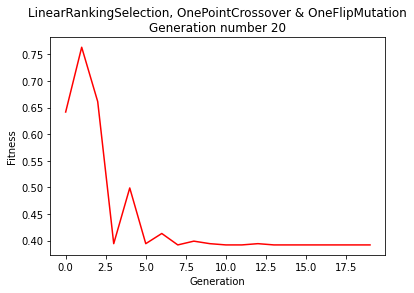

In [21]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
POPULATION_SIZE = 20
GEN_SIZE_1 = 10
SELECTED_SIZE = 15
CROSSOVER_PROBABILITY = 0.8
MUTATION_PROBABILITY = 0.01
eps_1 = (domain_1[1] - domain_1[0]) / (2**GEN_SIZE_1 - 1)

args = IndividualArguments(domain_1, eps_1, n_var_1, GEN_SIZE_1)
initial_population = [Individual.newRandom(args) for _ in range(POPULATION_SIZE)]

# PIPELINE GA TOURNAMENT SELECTION
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                           fitness=F1,
                           population=initial_population,
                           selection=LinearRankingSelection(num_individuals=SELECTED_SIZE, s=1.5),
                           crossover=OnePointCrossover(probability=CROSSOVER_PROBABILITY),
                           mutation=OneFlipMutation(probability=MUTATION_PROBABILITY))


In [22]:
solution1 = min(best, key=lambda x: F1(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution1.phenotype}, f(x*) = {F1(solution1.phenotype)}")


Optimal value with Tournament Selection
 x* = [-0.16911045943304004, 0.04398826979472137, 0.6011730205278591], f(x*) = 0.39194231597977686


Generación: 2, número de descendientes: 12
Generación: 4, número de descendientes: 8
Generación: 6, número de descendientes: 12
Generación: 8, número de descendientes: 12
Generación: 10, número de descendientes: 10
Generación: 12, número de descendientes: 12
Generación: 14, número de descendientes: 12
Generación: 16, número de descendientes: 11
Generación: 18, número de descendientes: 14
Generación: 20, número de descendientes: 13


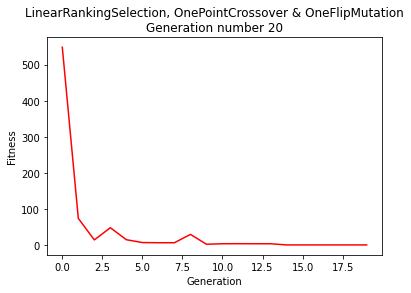

In [23]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
POPULATION_SIZE = 20
GEN_SIZE_2 = 10
SELECTED_SIZE = 15
CROSSOVER_PROBABILITY = 0.8
MUTATION_PROBABILITY = 0.01
eps_2 = (domain_2[1] - domain_2[0]) / (2**GEN_SIZE_2 - 1)

args = IndividualArguments(domain_2, eps_2, n_var_2, GEN_SIZE_2)
initial_population = [Individual.newRandom(args) for _ in range(POPULATION_SIZE)]

# PIPELINE GA TOURNAMENT SELECTION
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                           fitness=F2,
                           population=initial_population,
                           selection=LinearRankingSelection(num_individuals=SELECTED_SIZE, s=1.5),
                           crossover=OnePointCrossover(probability=CROSSOVER_PROBABILITY),
                           mutation=OneFlipMutation(probability=MUTATION_PROBABILITY))


In [24]:
solution2 = min(best, key=lambda x: F2(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution2.phenotype}, f(x*) = {F2(solution2.phenotype)}")


Optimal value with Tournament Selection
 x* = [0.8035190615835779, 0.5219941348973607], f(x*) = 1.5675060332813993
